<a href="https://colab.research.google.com/github/glorivaas/Risk_Measures/blob/main/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Options 101

### Exercise 1
Implement Black-Scholes European option pricing and sensitivities formulas.
Use "ACT/360" daycount convention to calculate time to expiry.

For an option with strike = 100 and tte = 1.0, plot payoff, price and sensitivities against varying market quantities (separately for call and put).

##**UNDERSTANDING OF THE CONCEPTS**
(as I am not very familiar with them, and I find it useful to have it here)

An **option** is a contract that gives you the right  to buy or sell a stock in the future at a fixed price.

- A **Call Option** lets you **buy** the stock.
- A **Put Option** lets you **sell** the stock.

You choose a price (called the **strike price**) and a date in the future (called the **maturity**).

We will also use the sensivities (also refered as Geeks) :

| Name   | What it measures                             |
|--------|----------------------------------------------|
| Delta  | How much the option price changes if the stock price changes |
| Gamma  | How much Delta changes if the stock price changes |
| Vega   | How much the price changes if volatility changes |
| Theta  | How much the price changes as time passes |
| Rho    | How much the price changes if interest rates change |

In [6]:
from dataclasses import dataclass

import numpy as np
from scipy.stats import norm
from dataclasses import dataclass

@dataclass
class EuropeanOption:
    is_call: bool
    strike: float
    maturity: np.datetime64

@dataclass
class BlackScholesMarket:
    valuation_date: np.datetime64
    spot: float
    implied_volatility: float
    risk_free_rate: float

@dataclass
class BlackScholesEngine:
    deal: EuropeanOption
    market: BlackScholesMarket

    def _time_to_expiry(self) -> float:
      """Calculate time to expiry using ACT/360 convention."""
      days_to_expiry = (self.deal.maturity - self.market.valuation_date).astype(int)
      return days_to_expiry / 360

    def _d1_d2(self):
        T = self._time_to_expiry()
        S = self.market.spot
        K = self.deal.strike
        r = self.market.risk_free_rate
        σ = self.market.implied_volatility

        d1 = (np.log(S / K) + (r + 0.5 * σ ** 2) * T) / (σ * np.sqrt(T))
        d2 = d1 - σ * np.sqrt(T)
        return d1, d2

    def payoff(self) -> float:
        if self.deal.is_call:
            return max(self.market.spot - self.deal.strike, 0)
        else:
            return max(self.deal.strike - self.market.spot, 0)

    def price(self) -> float:
        S = self.market.spot
        K = self.deal.strike
        r = self.market.risk_free_rate
        T = self._time_to_expiry()
        d1, d2 = self._d1_d2()

        if self.deal.is_call:
            return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        else:
            return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    def delta(self) -> float:
        d1, _ = self._d1_d2()
        return norm.cdf(d1) if self.deal.is_call else -norm.cdf(-d1)

    def gamma(self) -> float:
        S = self.market.spot
        T = self._time_to_expiry()
        σ = self.market.implied_volatility
        d1, _ = self._d1_d2()
        return norm.pdf(d1) / (S * σ * np.sqrt(T))

    def theta(self) -> float:
        S = self.market.spot
        K = self.deal.strike
        r = self.market.risk_free_rate
        σ = self.market.implied_volatility
        T = self._time_to_expiry()
        d1, d2 = self._d1_d2()

        term1 = - (S * norm.pdf(d1) * σ) / (2 * np.sqrt(T))
        if self.deal.is_call:
            term2 = -r * K * np.exp(-r * T) * norm.cdf(d2)
            return term1 + term2
        else:
            term2 = r * K * np.exp(-r * T) * norm.cdf(-d2)
            return term1 + term2

    def vega(self) -> float:
        S = self.market.spot
        T = self._time_to_expiry()
        d1, _ = self._d1_d2()
        return S * norm.pdf(d1) * np.sqrt(T)

    def rho(self) -> float:
        K = self.deal.strike
        T = self._time_to_expiry()
        r = self.market.risk_free_rate
        d1, d2 = self._d1_d2()

        if self.deal.is_call:
            return K * T * np.exp(-r * T) * norm.cdf(d2)
        else:
            return -K * T * np.exp(-r * T) * norm.cdf(-d2)

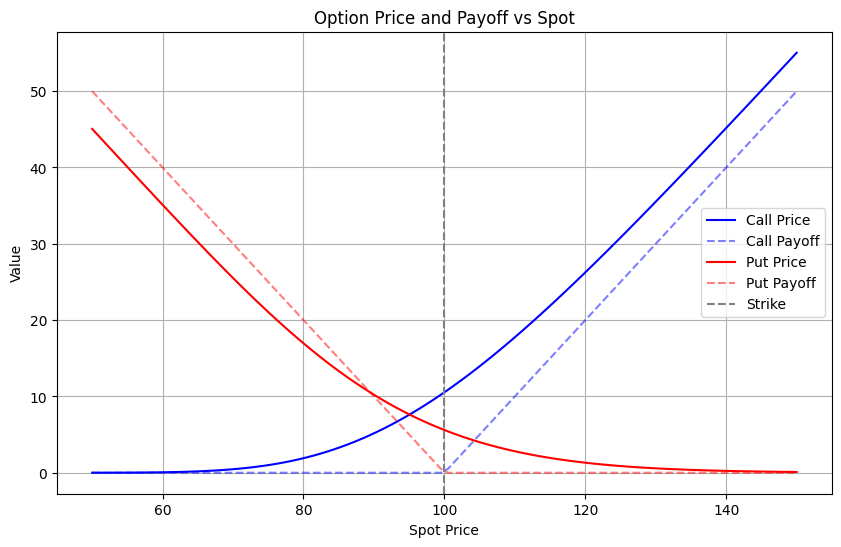

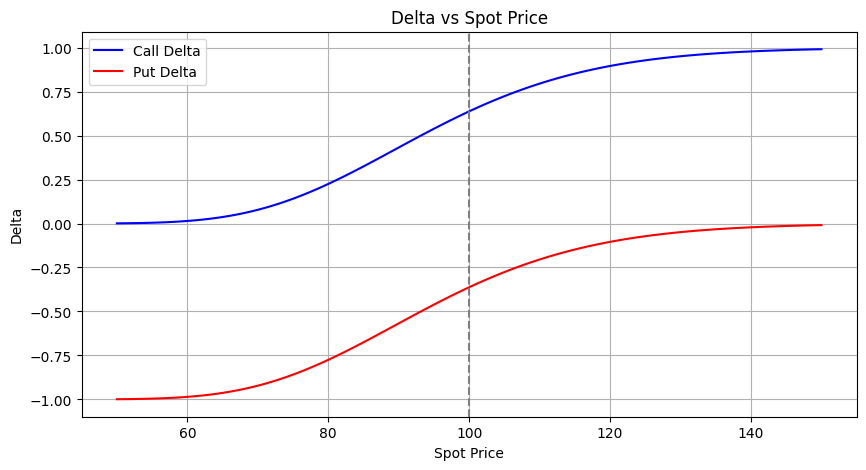

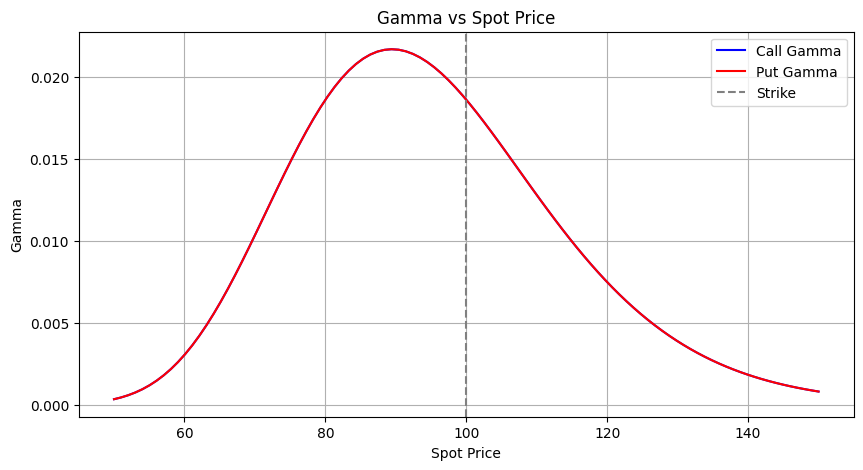

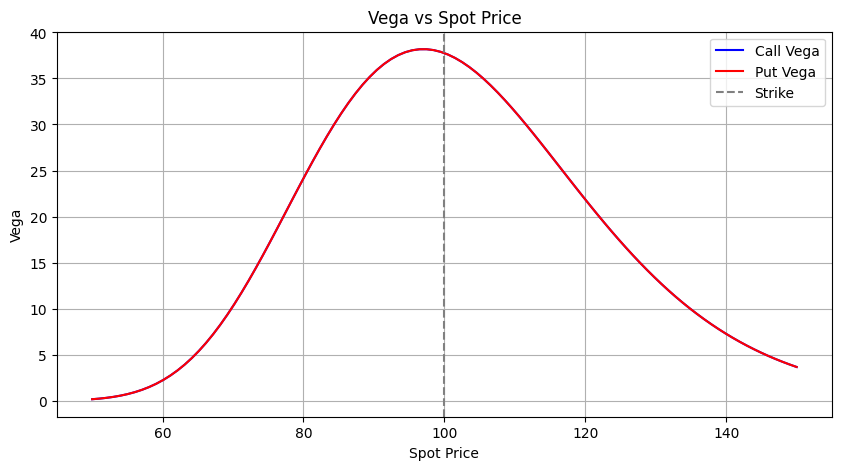

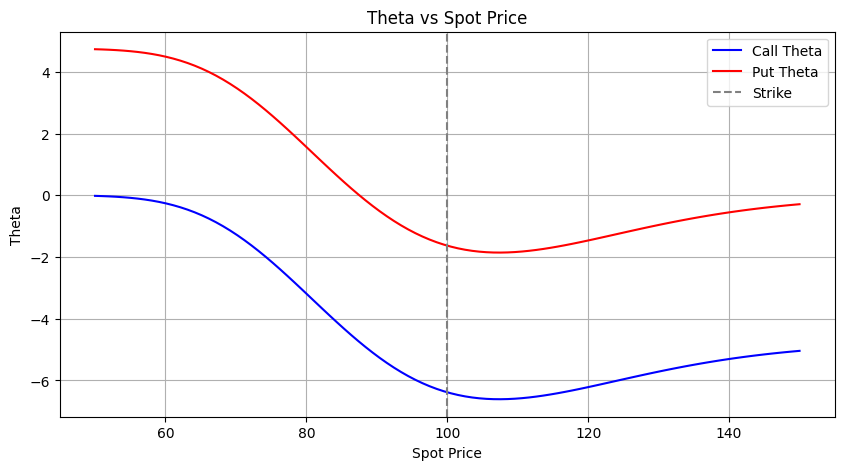

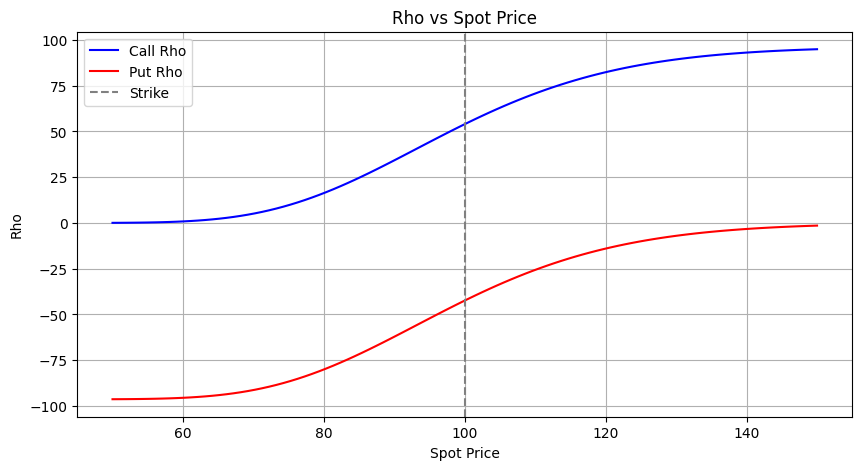

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Fixed option parameters
strike = 100
maturity = np.datetime64('2026-01-01')
valuation_date = np.datetime64('2025-01-01')

# Varying spot prices
spots = np.linspace(50, 150, 100)
vol = 0.2
r = 0.05

# Prepare arrays
call_prices, put_prices = [], []
call_deltas, put_deltas = [], []
call_vegas, put_vegas = [], []
call_gammas, put_gammas = [], []
call_thetas, put_thetas = [], []
call_rhos, put_rhos = [], []
call_payoffs, put_payoffs = [], []

for s in spots:
    market = BlackScholesMarket(valuation_date, s, vol, r)
    call = EuropeanOption(True, strike, maturity)
    put = EuropeanOption(False, strike, maturity)

    call_engine = BlackScholesEngine(call, market)
    put_engine = BlackScholesEngine(put, market)

    call_prices.append(call_engine.price())
    put_prices.append(put_engine.price())

    call_deltas.append(call_engine.delta())
    put_deltas.append(put_engine.delta())

    call_gammas.append(call_engine.gamma())
    put_gammas.append(put_engine.gamma())

    call_vegas.append(call_engine.vega())
    put_vegas.append(put_engine.vega())

    call_thetas.append(call_engine.theta())
    put_thetas.append(put_engine.theta())

    call_rhos.append(call_engine.rho())
    put_rhos.append(put_engine.rho())

    call_payoffs.append(max(s - strike, 0))
    put_payoffs.append(max(strike - s, 0))

plt.figure(figsize=(10, 6))
plt.plot(spots, call_prices, label="Call Price", color='blue')
plt.plot(spots, call_payoffs, '--', label="Call Payoff", color='blue', alpha=0.5)
plt.plot(spots, put_prices, label="Put Price", color='red')
plt.plot(spots, put_payoffs, '--', label="Put Payoff", color='red', alpha=0.5)
plt.axvline(strike, color='gray', linestyle='--', label='Strike')
plt.title("Option Price and Payoff vs Spot")
plt.xlabel("Spot Price")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(spots, call_deltas, label='Call Delta', color='blue')
plt.plot(spots, put_deltas, label='Put Delta', color='red')
plt.axvline(strike, color='gray', linestyle='--')
plt.title("Delta vs Spot Price")
plt.xlabel("Spot Price")
plt.ylabel("Delta")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(spots, call_gammas, label='Call Gamma', color='blue')
plt.plot(spots, put_gammas, label='Put Gamma', color='red')
plt.axvline(strike, color='gray', linestyle='--', label='Strike')
plt.title("Gamma vs Spot Price")
plt.xlabel("Spot Price")
plt.ylabel("Gamma")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(spots, call_vegas, label='Call Vega', color='blue')
plt.plot(spots, put_vegas, label='Put Vega', color='red')
plt.axvline(strike, color='gray', linestyle='--', label='Strike')
plt.title("Vega vs Spot Price")
plt.xlabel("Spot Price")
plt.ylabel("Vega")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(spots, call_thetas, label='Call Theta', color='blue')
plt.plot(spots, put_thetas, label='Put Theta', color='red')
plt.axvline(strike, color='gray', linestyle='--', label='Strike')
plt.title("Theta vs Spot Price")
plt.xlabel("Spot Price")
plt.ylabel("Theta")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(spots, call_rhos, label='Call Rho', color='blue')
plt.plot(spots, put_rhos, label='Put Rho', color='red')
plt.axvline(strike, color='gray', linestyle='--', label='Strike')
plt.title("Rho vs Spot Price")
plt.xlabel("Spot Price")
plt.ylabel("Rho")
plt.legend()
plt.grid(True)
plt.show()


##**COMMENTING THE RESULTS**
1. **Option price and payoff vs spot price**

  This plot compares the actual option prices (curved lines) to their payoffs at expiry (dashed lines).

  - The **call price (blue)** increases as the spot price goes above the strike, because the option becomes more valuable.
  - The **put price (red)** increases as the spot price goes below the strike.

- The **dashed lines** show the payoff at expiry. They are sharp and straight because, at expiry, the option is either worth something or nothing.
- The **solid lines** show the current market prices of the options. These are curved because they reflect uncertainty and the time left before expiry.
- The **call option** becomes more valuable as the stock price increases — this is why the blue lines go up.
- The **put option** becomes more valuable as the stock price decreases — this is why the red lines go up on the left side.
- Both options are worth **more than their payoffs** before expiry because of the **time value** — the possibility that prices might move further in your favor.

This plot visually confirms how options are priced higher than their raw payoff because they offer potential — not just a fixed result.

🔹 The red lines (put payoff and put price) intersect close to the strike price. This shows the point where the market price of the put option equals its direct value at expiry. After this point, the put price falls below its payoff, because it's less likely to end in the money and has less time value left.

### 🔍 Comment on Delta vs Spot Price Plot

This plot shows how the Delta of call and put options changes as the stock price moves.

- The **call Delta (blue)** increases from 0 to 1 as the stock price rises. This means the call option behaves more and more like owning the stock itself.
- The **put Delta (red)** increases from -1 to 0 as the stock price rises. This means the put becomes less sensitive to price changes as it goes out of the money.
- Around the **strike price (100)**, both lines curve sharply — this is where the option is most sensitive to small movements in the stock.
- At the far ends, both Deltas flatten, showing that very deep in-the-money or out-of-the-money options change slowly with price.

Delta helps estimate how much the option price moves when the stock price changes.

🔍 This plot shows how Gamma behaves as the stock price changes.

- Gamma measures how quickly Delta changes.
- It peaks near the **strike price**, where the option is most sensitive to price movements.
- Both call and put options have the same Gamma in the Black-Scholes model, which is why the two lines overlap.
- Gamma drops to near zero when the option is far in or out of the money.

🔍 This plot shows how Vega changes with the stock price.

- Vega measures how much the option price changes if the **volatility** increases.
- It is highest when the stock price is near the **strike**.
- This makes sense because uncertainty (volatility) matters most when the outcome is unclear.
- Both call and put Vegas are equal here, so the two lines overlap.

🔍 This plot shows how the option's value changes over time (Theta).

- Theta is usually **negative**, meaning the option loses value as time passes.
- The call Theta (blue) is more negative, especially near the strike.
- The put Theta (red) is less negative or even positive in some regions — this depends on how deep in or out of the money it is.
- This plot shows that **time decay affects calls and puts differently**.

🔍 This plot shows how sensitive the option price is to changes in the interest rate (Rho).

- The **call Rho (blue)** is positive — higher interest rates make call options more valuable.
- The **put Rho (red)** is negative — higher interest rates make put options less valuable.
- Rho increases (or decreases) more sharply around the strike price, where the option is more likely to be exercised.


### Exercise 2

Fit Cauchy distribution to SPX500 returns data from the last 5 years.

Consider a portfolio containing a single European call option with maturity 5.11.2025.

Calculate daily VaR at level 95% (L/P) at 5.05.2025 using the following approaches:
- variance-covariance with linearized loss (delta-theta approximation)
- variance-covariance using 2nd order approximation (include gamma)
- numerical integration (Monte Carlo)

Compare performance of the variance-covariance methods against numerical integration for various strikes (log-moneyness).

Assume risk-free rate of 2% and flat implied volatility equal to 30%.

In [ ]:
@dataclass
class SimpleVarEngine:
    spx_data: list[float]
    rfr: float = 0.02
    iv: float = 0.3

    def __post_init__(self) -> None:
        # transform data, fit Cauchy, set parameters, etc.
        ...

    def delta_var(
        self,
        moneyness: float
    ) -> float:
        ...

    def delta_gamma_var(
        self,
        moneyness: float
    ) -> float:
        ...

    def monte_carlo_var(
        self,
        moneyness: float
    ) -> float:
        ...


### Exercise 3

In the setting of Exercise 2, include volatility and risk-free rate shocks, that are independent of each other and on spot dynamics.
Assume that:
- risk-free rate **absolute** change follows uniform distribution in the set [-100bp, 0, +100bp, +200bp, +300bp]
- implied volatility **relative** change follows exponential distribution with parameter 1.0

Compare the performance of each of the method (use all derivatives for variance-covariance).

In [ ]:
@dataclass
class VarEngine:
    spx_data: list[float]
    rfr: 0.02
    iv: 0.3

    def __post_init__(self) -> None:
        # transform data, fit Cauchy, set parameters, etc.
        ...

    def variance_covariance_full_var(
        self,
        moneyness: float
    ) -> float:
        ...

    def monte_carlo_full_var(
        self,
        moneyness: float
    ) -> float:
        ...